In [9]:
import pandas as pd


df_combined = pd.read_excel("bee_data_with_features1.xlsx")
df_combined = df_combined.sample(frac=1).reset_index(drop=True)


In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# Features and labels
X = df_combined.drop(columns=["file name", "date", "device", "hive number", "queen presence", "queen acceptance", "target"])
y = df_combined["queen acceptance"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode y labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Class weights (you can also compute automatically with 'balanced')
class_weight = {
    le.transform([2])[0]: 1,
    le.transform([1])[0]: 1.5
}

# RandomForest classifier
rf = RandomForestClassifier(
    class_weight=class_weight,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

# Hyperparameter tuning (optional)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],  # no 'None'
    'min_samples_split': [5, 10, 20],  # avoid small splits
    'min_samples_leaf': [2, 5, 10]     # force trees to have more samples in leaves
}
grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train, y_train)

# Prediction
y_pred = grid.best_estimator_.predict(X_test)

# Evaluation
print("Best Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in le.classes_]))
print("Train accuracy:", grid.best_estimator_.score(X_train, y_train))
print("Test accuracy:", grid.best_estimator_.score(X_test, y_test))



Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           1       0.99      0.95      0.97      1904
           2       0.97      0.99      0.98      2576

    accuracy                           0.97      4480
   macro avg       0.98      0.97      0.97      4480
weighted avg       0.97      0.97      0.97      4480

Train accuracy: 0.9814701121839594
Test accuracy: 0.9741071428571428


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Features and labels
X = df_combined.drop(columns=["file name", "date", "device", "hive number", "queen presence", "queen acceptance", "target"])
y = df_combined["queen acceptance"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Class weights (optional – based on value counts)
class_weight = {
    2: 1,
    1: 1.5
}

# RandomForest classifier with mild regularization
rf = RandomForestClassifier(
    n_estimators=75,              # Slightly fewer trees
    max_depth=6,                 # Prevent overly deep trees
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',          # Helps reduce tree correlation
    class_weight=class_weight,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print("OOB Score:", rf.oob_score_)
print(classification_report(y_test, y_pred))
print("Train accuracy:", rf.score(X_train, y_train))
print("Test accuracy:", rf.score(X_test, y_test))



OOB Score: 0.9069040575989283
              precision    recall  f1-score   support

           1       0.95      0.84      0.89      1904
           2       0.89      0.97      0.93      2576

    accuracy                           0.91      4480
   macro avg       0.92      0.90      0.91      4480
weighted avg       0.92      0.91      0.91      4480

Train accuracy: 0.9155550594407545
Test accuracy: 0.9133928571428571


In [18]:
import joblib

joblib.dump(rf, 'queen_acceptance_rf_model.pkl')


['queen_acceptance_rf_model.pkl']

In [13]:
count = (df_combined["queen acceptance"] == 2).sum()
print(count)

13079


In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import numpy as np
import pandas as pd

# Features and labels
X = df_combined.drop(columns=["file name", "date", "device", "hive number", "queen presence", "queen acceptance", "target"])
y = df_combined["queen acceptance"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split

# Encode y labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Check encoded classes
print("Encoded classes:", list(le.classes_))
print("Encoded labels:", np.unique(y_encoded))

# Define custom weights (example: give higher weight to minority class if needed)
# Automatically set 1.5 to the minority class and 1.0 to the majority
unique, counts = np.unique(y_encoded, return_counts=True)
minority_class = unique[np.argmin(counts)]

# Set weights: higher weight for minority
class_weight = {int(cls): (1.5 if cls == minority_class else 1.0) for cls in unique}

print("Final class weights:", class_weight)
# Compute class weights to handle imbalance
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weight_dict = {i: w for i, w in zip(np.unique(y_train), class_weight)}

# LightGBM classifier with weights
# lgbm = lgb.LGBMClassifier(class_weight=weight_dict, random_state=42)
lgbm = lgb.LGBMClassifier(
    num_leaves=15,
    max_depth=5,
    min_child_samples=30,
    class_weight=class_weight,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    lambda_l1=0.5,
    lambda_l2=0.5,
    random_state=42
)

# Hyperparameter tuning (optional, for speed can be skipped initially)
param_grid = {
    'num_leaves': [15, 31, 63],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}
grid = GridSearchCV(lgbm, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train, y_train)

# Final prediction
y_pred = grid.best_estimator_.predict(X_test)

# Evaluation
print("Best Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred))


Encoded classes: [1, 2]
Encoded labels: [0 1]
Final class weights: {0: 1.5, 1: 1.0}


ValueError: 
All the 162 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Anaconda 3\envs\installingrasa\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Anaconda 3\envs\installingrasa\lib\site-packages\lightgbm\sklearn.py", line 1518, in fit
    self._class_weight = {self._class_map[k]: v for k, v in self.class_weight.items()}
  File "d:\Anaconda 3\envs\installingrasa\lib\site-packages\lightgbm\sklearn.py", line 1518, in <dictcomp>
    self._class_weight = {self._class_map[k]: v for k, v in self.class_weight.items()}
KeyError: 0


In [ ]:
print(y)

0        1
1        1
2        1
3        1
4        2
        ..
22392    2
22393    2
22394    2
22395    1
22396    1
Name: queen acceptance, Length: 22397, dtype: int64


In [ ]:
from sklearn.metrics import classification_report

# Train set prediction
y_train_pred = grid.best_estimator_.predict(X_train)

# Evaluate on training set
print("\n--- Training Set Report ---")
print(classification_report(y_train, y_train_pred))

# Evaluate on test set (already done)
print("\n--- Test Set Report ---")
print(classification_report(y_test, y_pred))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

--- Training Set Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7451
           1       1.00      1.00      1.00     10466

    accuracy                           1.00     17917
   macro avg       1.00      1.00      1.00     17917
weighted avg       1.00      1.00      1.00     17917


--- Test Set Report ---
              precision    recall  f1-score   support

        

In [ ]:
from sklearn.model_selection import cross_val_score

# 5-Fold Cross-validation on full dataset (using scaled X and y)
cv_scores = cross_val_score(grid.best_estimator_, X_scaled, y, cv=5, scoring='f1_weighted')
print("\n--- Cross-Validation Scores (5-Fold, F1 Weighted) ---")
print("Scores:", cv_scores)
print("Mean:", np.mean(cv_scores))
print("Std Dev:", np.std(cv_scores))


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Anaconda 3\envs\installingrasa\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Anaconda 3\envs\installingrasa\lib\site-packages\lightgbm\sklearn.py", line 1518, in fit
    self._class_weight = {self._class_map[k]: v for k, v in self.class_weight.items()}
  File "d:\Anaconda 3\envs\installingrasa\lib\site-packages\lightgbm\sklearn.py", line 1518, in <dictcomp>
    self._class_weight = {self._class_map[k]: v for k, v in self.class_weight.items()}
KeyError: 0


In [ ]:
import matplotlib.pyplot as plt

# If you want to show feature names
feature_names = df_combined.drop(columns=["file name", "date", "device", "hive number", "queen presence", "queen acceptance", "target"]).columns

lgb.plot_importance(grid.best_estimator_, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances")
plt.xticks(rotation=45)
plt.show()


ValueError: not enough values to unpack (expected 2, got 0)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=

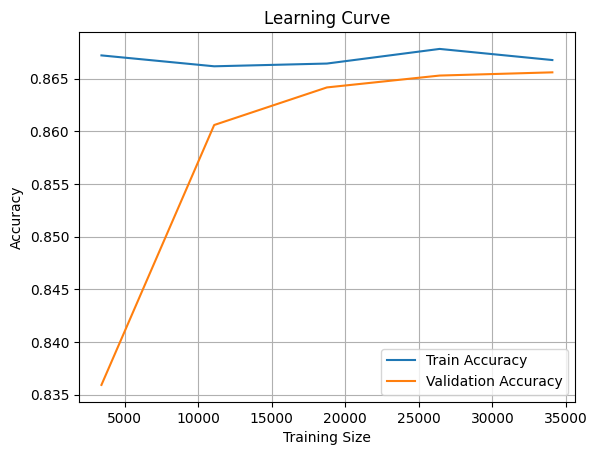

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(grid.best_estimator_, X_scaled, y, cv=5, scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Train Accuracy")
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import joblib

# Create a dictionary of all components
model_package = {
    'model': grid.best_estimator_,
    'scaler': scaler,
    'label_encoder': le
}

# Save the entire package
joblib.dump(model_package, 'queen_acceptance_model_package.pkl')

['queen_acceptance_model_package.pkl']